In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
df= pd.read_csv('sea_ice_data/sea-ice-timeseries.txt', header=None, names=['date', 'ice'], parse_dates=['date'])

In [4]:
df['ice'] -= df['ice'].mean()
df['ice'] /= df['ice'].std()

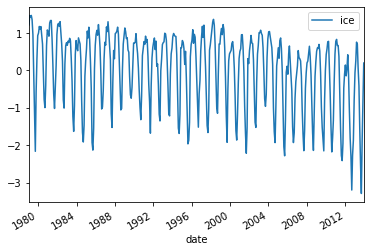

In [5]:
df.plot(x='date', y='ice')

In [9]:
with pm.Model() as model:
    # prior on length scale of kernel
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    # prior on correlation strength
    η = pm.HalfCauchy("η", beta=3)
    # kernel
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)

    # looking at last 48
    X = np.array(df.index)[-48:-1,None]
    # informative prior on degrees of freedom < 5
    ν = pm.Gamma("ν", alpha=2, beta=1)
    tp = pm.gp.TP(cov_func=cov, nu=ν)
    f = tp.prior("f", X=X)

    # sd here should be observational error
    y_ = pm.Normal("y", mu=f, sd=0.1, observed=df['ice'][-48:-1])

    # not sure what sampler to use / how long to run it for
    #step = pm.Metropolis()
    #tr = pm.sample(10000, tune=1000, step=step)
    tr = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, chi2_, ν, η, ℓ]
Sampling 4 chains: 100%|██████████| 4000/4000 [18:25<00:00,  1.62draws/s] 
The acceptance probability does not match the target. It is 0.8905506001280562, but should be close to 0.8. Try to increase the number of tuning steps.
There were 484 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.09807641038025569, but should be close to 0.8. Try to increase the number of tuning steps.
There were 471 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10612174490716017, but should be close to 0.8. Try to increase the number of tuning steps.
There were 425 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It i

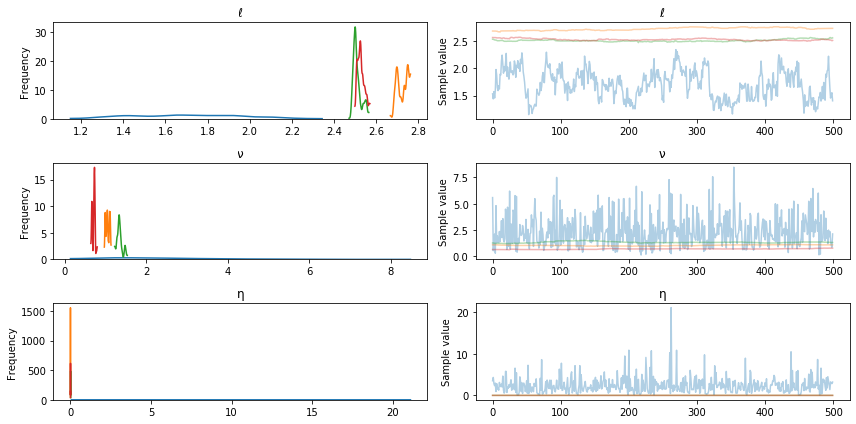

In [10]:
pm.traceplot(tr, varnames=["ℓ", "ν", "η"]);

In [11]:
X = np.array(df.index)[-48:-1,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = tp.conditional("f_pred", X)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(tr, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:28<00:00, 35.17it/s]


/astro/users/sportill/.conda/envs/AHW19/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


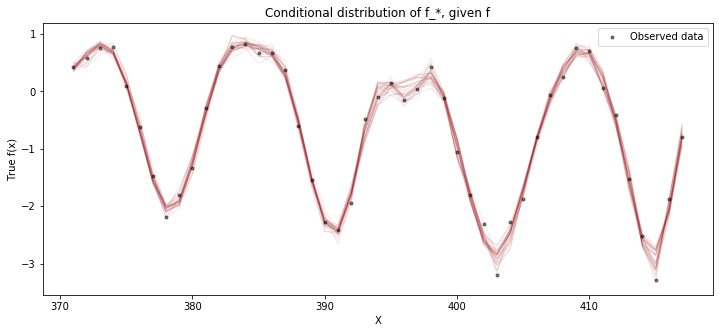

In [12]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X);
plt.plot(X, df['ice'][-48:-1], 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();